In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

import gymnasium as gym
from gymnasium import spaces, Env

import random

# import clear_output
import os

from stable_baselines3 import PPO 
from stable_baselines3.common.env_util import make_vec_env

Hei jake, her er noen ting å tenke på

- Det blir lagt til en ekstra asset som ikke er aksje, typ aksjesparekonto antar jeg som ikke gir avkastning eller downside. vi kan beholde dette men tenker vi burde være klar over hva det betyr og gjør. 

- Det virker ikke som modellen finner noe. Siste cellen plotter metrics på hverandre. utfallet av disse virker helt tilfedlig og har så godt som ingen kontinuitet. Mulig vi kunne kjørt masse simulasjoner for å finne noe, treningen virker å være veldig tilfeldig, men litt sånn RL funker kanskje. 

Ting vi må finne ut av:
- Beregne performance av porteføljene dvs en tabell over alle metrics for hver portefølje. 
- Vektene beregnes jo hver dag så det er helt kaos, men hadde vært noe med en oversikt der også uten at jeg tror det vil gi noe mening.
- Jeg har ikke klart å hente ut asset weigths på en meningsfull måte skjer noe veldig feil da og de trenger vi vel til BHB
- Modellen vi benytter er PPO, mener fortsatt at vi egt burde ha noe litteratur grunnlag for å bruke noe annet enn Q-learning eller PPO som basert på min lesing er de mest vanlig RL metodene. 

Lykke til :)

Assumptions

- Unrealistic treatment of prices and returns(Transaction costs, bid-ask spreads)
- ESG score implementation(too simplistic, consider penalty that increases as portolio deviates from ideal ESG score)
- Cannot short stocks( solution is to expand agents action set)
- includes risk free placement (aksjesparekonto)

## STONKS ##
# Petroleum
# EQNR 36.6, AKRBP 35.3, Subsea7 17.9, BWO 18.0

# Food (Seafood)
# Orkla 18, Mowi 21.2, Salmar 18.7, LSG 29.2

# Materials
# NHY 15.7, Yara 25.6, RECSI 25.6, BRG(2012) 18.4, 

# Technologies
# TEL 19.8, NOD 13.8, ATEA 18.1, BOUV 19

# Financials
# STB 17.2, DNB 14, GJF(2010) 17.2, MING.OL 19.5

# Shipping
# WAWI(2010) 19.7, SNI 21.2, BELCO 26.8, ODF 19.3

# Current data requires earliest year to be 2013. 

In [22]:
def dataRetriever(ticker_list):
    df = []
    for i in range(0,len(ticker_list),1):
        individual_stock_data = yf.download(ticker_list[i], start="2015-02-19", end="2025-02-18")
        df.append(individual_stock_data)
    return df

In [23]:
my_stocks = ["EQNR.OL", "AKRBP.OL", "SUBC.OL", "BWO.OL",
            "ORK.OL", "MOWI.OL", "SALM.OL", "LSG.OL",
            "NHY.OL", "YAR.OL", "RECSI.OL", "BRG.OL",
            "TEL.OL", "NOD.OL", "ATEA.OL", "BOUV.OL",
            "STB.OL", "DNB.OL", "GJF.OL", "MING.OL",
            "WAWI.OL", "SNI.OL", "BELCO.OL", "ODF.OL"]
my_data = dataRetriever(my_stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

https://medium.com/@paulswenson2/an-introduction-to-building-custom-reinforcement-learning-environment-using-openai-gym-d8a5e7cf07ea

In [18]:
close_values = [[my_data[0]["Close"].iloc[x][0],my_data[1]["Close"].iloc[x][0],my_data[2]["Close"].iloc[x][0],my_data[3]["Close"].iloc[x][0],my_data[4]["Close"].iloc[x][0]] for x in range(0, my_data[0].shape[0])]
esg_scores = [36 ,25, 29, 35, 16]

In [24]:
#close_values = [[my_data[i]["Close"].iloc[x][0] for i in range(len(my_data))] for x in range(my_data[0].shape[0])]
close_values = [[my_data[i]["Close"].iloc[x][0] for i in range(len(my_data))] 
                for x in range(min([len(my_data[i]["Close"]) for i in range(len(my_data))]))]

esg_scores = [36.6, 35.3, 17.9, 18, 
              18, 21.2, 18.7, 29.2, 
              15.7, 25.6, 25.6, 18.4, 
              19.8, 13.8, 18.1, 19, 
              17.2, 14, 17.2, 19.5, 
              19.7, 21.2, 26.8, 19.3]

In [25]:
class PortfolioEnv(Env):

    def __init__(self, stock_data, esg_data, reward_metric):
        """
        Custom portfolio management environment
        """

        # Define necessary market data
        self.prices = np.array(stock_data)
        self.esg_scores = np.array(esg_data)
        self.num_stocks = self.prices.shape[1]
        self.lookback = 10
        self.initial_cash = 100
        self.reward_metric = reward_metric

        # What does this do?
        super().__init__()

        # Observational space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_stocks + 1), dtype=np.float32)
        # Action space
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_stocks + 1,), dtype=np.float32)

        self.reset()



    def reset(self, seed=None, options=None):
        """
        Resets the environment to the initial state
        """
        
        self.current_step = self.lookback 
        self.portfolio_value  = self.initial_cash
        self.weights = np.array([1 / (self.num_stocks+1)] * (self.num_stocks+1) )
        self.done = False

            # Track historical values for MDD and Calmar Ratio
        self.portfolio_history = [self.initial_cash]
        self.max_drawdown = 0.0
        self.returns_history = []

        return self._get_observation(), {}



    def step(self, action):
        """
        Executes an action and returns the next state
        """
        action = np.clip(action, 0, 1)

        # Prevent division by zero when normalizing actions
        if action.sum() == 0:
            action = np.ones_like(action) / len(action)  # Assign equal weights

        action /= action.sum()

        # Get price returns
        previous_prices = self.prices[self.current_step -1]
        current_prices = self.prices[self.current_step]
        returns = (current_prices - previous_prices) / previous_prices

        portfolio_return = np.dot(self.weights[:-1], returns)
        self.portfolio_value *= (1+ portfolio_return)


        # Track portfolio history for max drawdown calculations
        self.portfolio_history.append(self.portfolio_value)
        max_portfolio_value = max(self.portfolio_history)
        drawdown = (max_portfolio_value - self.portfolio_value) / max_portfolio_value
        self.max_drawdown = max(self.max_drawdown, drawdown)

        # Calculate ESG score
        esg_score = np.dot(self.weights[:-1], self.esg_scores)

        # Compute reward
        reward = self.calculate_reward(self.reward_metric, portfolio_return, esg_score)


        # Update portfolio weights
        self.weights = action
        self.current_step += 1 
        self.done = self.current_step  >= len(self.prices) - 1

        if np.isnan(action).any() or np.isinf(action).any():
            raise ValueError(f"Invalid action: {action}")

        return self._get_observation(), reward, self.done, False, {}


    def calculate_reward(self, metric, portfolio_return, esg_score):
        """ 
         Creates reward functions
        """

        # Penalty for non esg compliance(arbitrary as of now)
        esg_penalty = max(0, esg_score - 22)

        # Return
        if metric == "return":
            return portfolio_return - 0.1 * esg_penalty

        # Sharpe 
        elif metric == "sharpe":
            if self.current_step < 20:  
                return portfolio_return - 0.1 * esg_penalty
            past_returns = np.array(self.portfolio_history[-20:])
            volatility = np.std(past_returns) + 1e-6  
            return (portfolio_return / volatility) - 0.1 * esg_penalty

        # Sortino
        elif metric == "sortino":
            if self.current_step < 20:
                return portfolio_return - 0.1 * esg_penalty
            past_returns = np.array(self.portfolio_history[-20:])
            downside_returns = past_returns[past_returns < 0]
            if len(downside_returns) == 0:
                downside_volatility = 1e-6
            else: 
                downside_volatility = np.std(downside_returns) + 1e-6
            return portfolio_return / downside_volatility - 0.1 * esg_penalty

        # Calmar
        elif metric == "calmar":
            if self.max_drawdown == 0:
                return portfolio_return - 0.1 * esg_penalty 
            return portfolio_return / self.max_drawdown - 0.1 * esg_penalty


    def _get_observation(self):
        """ 
        Returns the current market state as observation 
        """
        prices = self.prices[self.current_step - self.lookback:self.current_step]  # Shape: (10, num_stocks)
        portfolio_state = np.full((self.lookback, 1), self.portfolio_value, dtype=np.float32)  # Shape: (10, 1)

        obs = np.hstack((prices, portfolio_state))  # Expected shape: (10, num_stocks + 1)
        return obs.astype(np.float32)  # Ensure dtype is correct


    def render(self):
        """
        Optional visualization
        """
        print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value:.2f}")


In [27]:
env = PortfolioEnv(close_values,  esg_scores, "return")
model = PPO("MlpPolicy", env , verbose=1)
model.learn(total_timesteps=100_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2166 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.5e+03      |
|    ep_rew_mean          | -340         |
| time/                   |              |
|    fps                  | 1203         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0121131465 |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.53        |
|    explained_variance   | -0.0412      |
|    learning_rate        | 0.0003       |
|    los

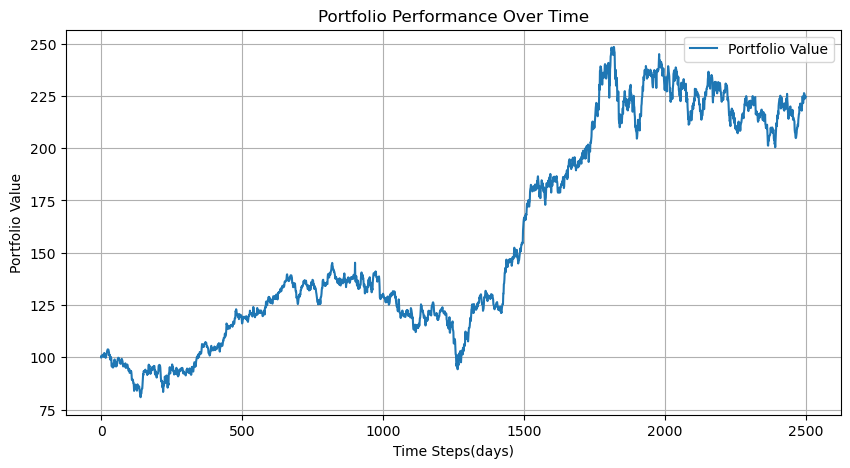

In [31]:

# Reset environment
obs, _ = env.reset()
done = False

# Store portfolio values
portfolio_values = [env.portfolio_value]

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Store value at each step

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Time Steps(days)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance Over Time")
plt.legend()
plt.grid()
plt.show()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 744      |
|    ep_rew_mean     | 0.457    |
| time/              |          |
|    fps             | 1102     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 744         |
|    ep_rew_mean          | 0.635       |
| time/                   |             |
|    fps                  | 611         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009004286 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss   

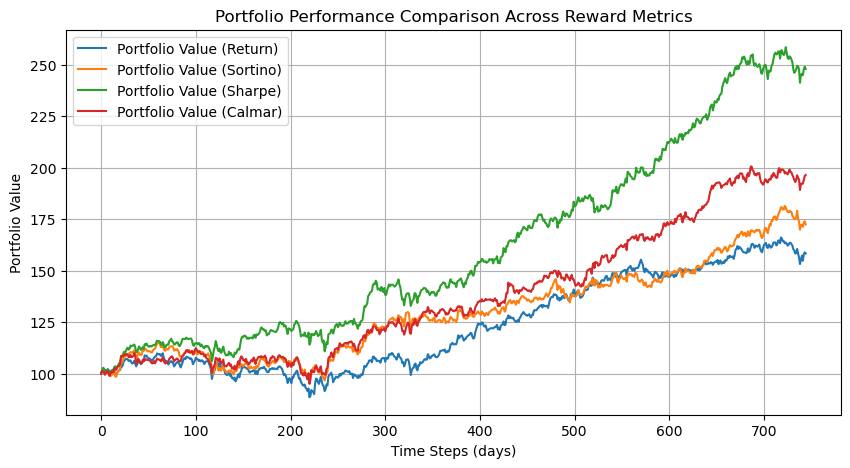

In [13]:

# List of reward metrics to compare
reward_metrics = ["return", "sortino", "sharpe", "calmar"]  # Add any other metrics you want to compare

# Store portfolio values for each metric
portfolio_values_dict = {}
weights_dict = {}


# Train and evaluate models for each reward metric
for metric in reward_metrics:

    # Create the environment with the current reward metric
    env = PortfolioEnv(close_values, esg_scores, metric)

    # Train the model
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10_000)

    # Reset environment
    obs, _ = env.reset()
    done = False

    # Store portfolio values
    portfolio_values = [env.portfolio_value]
    weights = [env.weights]
    

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        portfolio_values.append(env.portfolio_value)
        weights.append(env.weights)

    # Store the portfolio values for the current metric
    portfolio_values_dict[metric] = portfolio_values
    weights_dict[metric] = weights



# Plot the results for all reward metrics
plt.figure(figsize=(10, 5))
for metric, values in portfolio_values_dict.items():
    plt.plot(values, label=f"Portfolio Value ({metric.capitalize()})")

plt.xlabel("Time Steps (days)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance Comparison Across Reward Metrics")
plt.legend()
plt.grid()
plt.show()


In [ ]:


# List of reward metrics
reward_metrics = ["return", "sortino", "sharpe", "calmar"]
num_simulations = 10
num_timesteps = 2500  # Adjust based on your data

# Dictionary to store all portfolio values per metric
all_portfolio_values = {metric: [] for metric in reward_metrics}

# Run simulations
for metric in reward_metrics:
    for _ in range(num_simulations):
        env = PortfolioEnv(close_values, esg_scores, metric)
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=10_000)

        obs, _ = env.reset()
        done = False
        portfolio_values = []

        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _, _ = env.step(action)
            portfolio_values.append(env.portfolio_value)

        # Ensure all arrays are the same length
        while len(portfolio_values) < num_timesteps:
            portfolio_values.append(portfolio_values[-1])  # Pad with last value if shorter
        
        all_portfolio_values[metric].append(portfolio_values)

# Convert to numpy arrays
for metric in reward_metrics:
    all_portfolio_values[metric] = np.array(all_portfolio_values[metric])

# Plot results
plt.figure(figsize=(10, 5))

for metric in reward_metrics:
    mean_values = np.mean(all_portfolio_values[metric], axis=0)
    std_values = np.std(all_portfolio_values[metric], axis=0)
    
    # Plot mean line
    plt.plot(mean_values, label=f"{metric.capitalize()} (Mean)")
    
    # Add shaded region (± 1 std dev)
    plt.fill_between(range(num_timesteps),
                     mean_values - std_values,
                     mean_values + std_values,
                     alpha=0.2)

plt.xlabel("Time Steps (days)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance Across Reward Metrics")
plt.legend()
plt.grid()
plt.show()


In [26]:

# List of reward metrics
reward_metrics = ["return", "sortino", "sharpe", "calmar"]
save_path = "saved_models"
os.makedirs(save_path, exist_ok=True)  # Ensure directory exists

# Train models and save them
for metric in reward_metrics:
    env = PortfolioEnv(close_values, esg_scores, metric)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10_000)
    
    # Save model
    model.save(os.path.join(save_path, f"ppo_{metric}"))
    print(f"Model for {metric} saved.")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1125 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.5e+03     |
|    ep_rew_mean          | -42.3       |
| time/                   |             |
|    fps                  | 607         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016639352 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.5       |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.0003      |
|    loss               

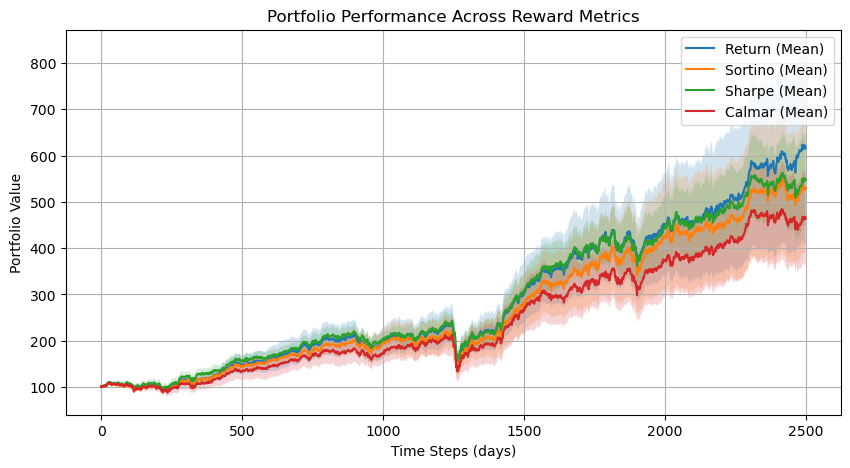

In [30]:
num_simulations = 10
num_timesteps = 2500  # Adjust based on your data

# Dictionary to store all portfolio values per metric
all_portfolio_values = {metric: [] for metric in reward_metrics}

# Load models and run simulations
for metric in reward_metrics:
    model = PPO.load(os.path.join(save_path, f"ppo_{metric}"))  # Load saved model

    for _ in range(num_simulations):
        env = PortfolioEnv(close_values, esg_scores, metric)
        obs, _ = env.reset()
        done = False
        portfolio_values = []

        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _, _ = env.step(action)
            portfolio_values.append(env.portfolio_value)
    

        # Ensure all arrays are the same length
        while len(portfolio_values) < num_timesteps:
            portfolio_values.append(portfolio_values[-1])  # Pad with last value if shorter
        
        all_portfolio_values[metric].append(portfolio_values)

# Convert to numpy arrays
for metric in reward_metrics:
    all_portfolio_values[metric] = np.array(all_portfolio_values[metric])

# Plot results
plt.figure(figsize=(10, 5))

for metric in reward_metrics:
    mean_values = np.mean(all_portfolio_values[metric], axis=0)
    std_values = np.std(all_portfolio_values[metric], axis=0)
    
    # Plot mean line
    plt.plot(mean_values, label=f"{metric.capitalize()} (Mean)")
    
    # Add shaded region (± 1 std dev)
    plt.fill_between(range(num_timesteps),
                     mean_values - std_values,
                     mean_values + std_values,
                     alpha=0.2)

plt.xlabel("Time Steps (days)")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance Across Reward Metrics")
plt.legend()
plt.grid()
plt.show()
